In [1]:
#NOTE: use paimg1 env, the retccl one has package issue with torchvision
import sys
import os
import numpy as np
import cv2
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import xml.etree.ElementTree as ET
from xml.dom import minidom
import geojson
import argparse
import matplotlib.pyplot as plt
import fastai
from fastai.vision.all import *
import PIL
matplotlib.use('Agg')
import pandas as pd
import datetime
from skimage import draw, measure, morphology, filters
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, shape
from shapely.ops import cascaded_union, unary_union
import json
import shapely
import warnings
from scipy import ndimage
sys.path.insert(0, '../Utils/')
from Preprocessing import preprocess_mutation_data, preprocess_site_data
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords
from Utils import do_mask_original,check_tissue,whitespace_check
from Utils import slide_ROIS
from Utils import get_downsample_factor, get_image_at_target_mag
from Utils import create_dir_if_not_exists
from Utils import get_map_startend
from Utils import cancer_mask_fix_res, tile_ROIS, check_any_invalid_poly, make_valid_poly
warnings.filterwarnings("ignore")

import pandas as pd
import torch, torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import ResNet as ResNet
from torch.utils.data import Dataset
import numpy as np
import os
import h5py
import time
from sklearn.model_selection import KFold, train_test_split
import numpy as np

import os
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import pandas as pd
import argparse
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
import torch
import torch.nn.functional as F

/home/jliu6/anaconda3/envs/paimg1/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/jliu6/anaconda3/envs/paimg1/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class pull_tiles(Dataset):
    def __init__(self, tile_info, deepzoom_tiles, tile_levels):
        super().__init__()
        self.tile_info = tile_info
        self.deepzoom_tiles = deepzoom_tiles
        self.tile_levels = tile_levels
        self.mag_extract = list(set(tile_info['MAG_EXTRACT']))[0]
        self.save_image_size = list(set(tile_info['SAVE_IMAGE_SIZE']))[0]


    def __getitem__(self, idx):
        #Get x, y index
        tile_ind = self.tile_info['TILE_XY_INDEXES'].iloc[idx].strip("()").split(", ")
        x ,y = int(tile_ind[0]) , int(tile_ind[1])

        #Pull tiles
        tile_pull = self.deepzoom_tiles.get_tile(self.tile_levels.index(self.mag_extract), (x, y))
        tile_pull = tile_pull.resize(size=(self.save_image_size, self.save_image_size),resample=PIL.Image.LANCZOS) #resize

        return tile_pull

In [3]:
# Min-max normalization function
def minmax_normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Function to convert coordinate string to dictionary
def convert_to_dict(row):
    coords = tuple(map(int, row['pred_map_location'].strip('()').split(', ')))
    return {'coords': coords, 'att': row['ATT']}

In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score,average_precision_score
from sklearn import metrics
import pandas as pd

def compute_performance(y_true,y_pred_prob,y_pred_class, cohort_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class).ravel() #CM

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
    
    # Average precision score = PR-AUC
    PR_AUC = average_precision_score(y_true, y_pred_prob)

    AUC = round(metrics.auc(fpr, tpr),2)
    ACC = round(accuracy_score(y_true, y_pred_class),2)
    F1 = round(f1_score(y_true, y_pred_class),2)
    F2 = round(fbeta_score(y_true, y_pred_class,beta = 2),2)
    F3 = round(fbeta_score(y_true, y_pred_class,beta = 3),2)
    Recall = round(recall_score(y_true, y_pred_class),2)
    Precision = round(precision_score(y_true, y_pred_class),2)
    Specificity = round(tn / (tn + fp),2)
    perf_tb = pd.DataFrame({"AUC": AUC, 
                            "ACC": ACC,
                            "F1": F1,
                            "F2": F2,
                            "F3": F3,
                            "Recall": Recall,
                            "Precision":Precision,
                            "Specificity":Specificity,
                            "PR_AUC":PR_AUC},index = [cohort_name])
    
    return perf_tb

In [6]:
def plot_LOSS (train_loss, valid_loss, outdir):
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(valid_loss,label="Validation")
    plt.plot(train_loss,label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(outdir + 'LOSS.png')
    
    
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [81]:
def log_message(message, file_name):
    """Logs a message to the specified file with a timestamp."""
    with open(file_name, 'a') as file:  # 'a' mode appends to the file
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        file.write(f'{timestamp} {message}\n')
        
class Mutation_MIL_MT(nn.Module):
    def __init__(self, in_features = 2048):
        super().__init__()
        self.in_features = in_features  
        self.L = 2048 # 512 node fully connected layer
        self.D = 128 # 128 node attention layer
        self.K = 1

        
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        # self.one_encoder = nn.Sequential()
        # for i in range(len(dim_list)-1):
        #     self.one_encoder.append(nn.Linear(dim_list[i], dim_list[i+1]))
        #     self.one_encoder.append(nn.ReLU(True))
        #     if i != (len(dim_list) - 2):
        #         self.one_encoder.append(nn.Dropout())
                
        self.embedding_layer = nn.Sequential(
            nn.Linear(self.in_features, 1024) #linear layer
            nn.Linear(1024, 512) #linear layer
            nn.Linear(512, 256) #linear layer
            nn.Linear(256, 128) #linear layer
        )
        
        self.ln_out1 = nn.Linear(128, 1) #linear layer
        self.ln_out2 = nn.Linear(128, 1) #linear layer
        self.ln_out3 = nn.Linear(128, 1) #linear layer
        self.ln_out4 = nn.Linear(128, 1) #linear layer
        self.ln_out5 = nn.Linear(128, 1) #linear layer
        self.ln_out6 = nn.Linear(128, 1) #linear layer
        self.ln_out7 = nn.Linear(128, 1) #linear layer
        
        
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        r'''
        x size: [1, N_TILE ,N_FEATURE]
        '''
        #attention
        A = self.attention(x) # NxK
        A = F.softmax(A, dim=1) # softmax over N
        M = x*A
        x = M.sum(dim=1) #N_Sample, 2048

        
        #Linear
        x = self.ln1(x) 
        x = self.ln2(x) 
        x = self.ln3(x) 
        x = self.ln4(x) 
        out1 = self.ln_out1(x) 
        out2 = self.ln_out2(x) 
        out3 = self.ln_out3(x) 
        out4 = self.ln_out4(x) 
        out5 = self.ln_out5(x) 
        out6 = self.ln_out6(x) 
        out7 = self.ln_out7(x) 

        #Drop out
        out1 = self.dropout(out1)  # Apply dropout
        out2 = self.dropout(out2)  # Apply dropout
        out3 = self.dropout(out3)  # Apply dropout
        out4 = self.dropout(out4)  # Apply dropout
        out5 = self.dropout(out5)  # Apply dropout
        out6 = self.dropout(out6)  # Apply dropout
        out7 = self.dropout(out7)  # Apply dropout
        
        # predict 
        y1 = torch.sigmoid(out1)
        y2 = torch.sigmoid(out2)
        y3 = torch.sigmoid(out3)      
        y4 = torch.sigmoid(out4)
        y5 = torch.sigmoid(out5)
        y6 = torch.sigmoid(out6)
        y7 = torch.sigmoid(out7)

        y = [y1, y2, y3, y4, y5, y6, y7]
        
        return y,A
        
class ModelReadyData_MT_V2(Dataset):
    def __init__(self,
                 feature_df,
                 label_df,
                ):
        
        self.x = torch.FloatTensor(feature_df)
        
        # Get the Y labels
        self.y = torch.FloatTensor(label_df)
        
    def __len__(self): 
        return len(self.x)
    
    def __getitem__(self,index):
        # Given an index, return a tuple of an X with it's associated Y
        x = self.x[index]
        y = self.y[index]
        
        return x, y

def get_feature_label_array(input_path, feature_folder, selected_ids,selected_labels, selected_feature):

    feature_label_list = []
    for pt in selected_ids:
        input_dir = input_path + pt + '/' + 'features/' + 'train_features_' + feature_folder + '.h5'
        cur_feature_df = pd.read_hdf(input_dir, key='feature')
        cur_feature_df.columns = cur_feature_df.columns.astype(str)
        cur_label_df = pd.read_hdf(input_dir, key='tile_info')[["SAMPLE_ID"] + selected_labels]
        cur_comb_df = pd.concat([cur_feature_df,cur_label_df], axis = 1) #Add ID and label to feature df
        feature_label_list.append(cur_comb_df)
        
    full_df = pd.concat(feature_label_list)
    
    
    #Get label numpy
    label_df = full_df[["SAMPLE_ID"] + selected_labels]
    label_df = label_df.drop_duplicates(subset= ['SAMPLE_ID'])
    label_array = label_df.drop(columns='SAMPLE_ID').values.astype('float32')
    
    #get feature numpy
    feature_df = full_df[["SAMPLE_ID"] + SELECTED_FEATURE]
    # Convert DataFrame to 3-D tensor
    feature_list = []    
    for group in list(label_df['SAMPLE_ID']):
        group_data = feature_df[feature_df['SAMPLE_ID'] == group].drop(columns='SAMPLE_ID').values
        feature_list.append(group_data)
    feature_3d = np.stack(feature_list)

    return feature_3d, label_array

In [8]:
##################
###### DIR  ######
##################
proj_dir = '/fh/scratch/delete90/etzioni_r/lucas_l/michael_project/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
model_path = proj_dir + 'models/feature_extraction_models/'
tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL100/'
ft_ids_path =  proj_dir + 'intermediate_data/cd_finetune/cancer_detection_training/' #the ID used for fine-tuning cancer detection model, needs to be excluded from mutation study
pretrain_model_name = 'retccl'

##################
#Select GPU
##################
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
################################################
#Create output dir
################################################
SELECTED_MUTATION = "MT"
model_name = "LinearMT" #Chose from Linear, LinearMT
outdir = proj_dir + "intermediate_data/pred_out/"  + SELECTED_MUTATION + "/saved_model/" + model_name + "/"
outdir2 = proj_dir + "intermediate_data/pred_out/" + SELECTED_MUTATION + "/model_para/"
outdir3 = proj_dir + "intermediate_data/pred_out/" + SELECTED_MUTATION + "/logs/"

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(outdir2):
    os.makedirs(outdir2)  
if not os.path.exists(outdir3):
    os.makedirs(outdir3)

In [10]:
############################################################################################################
#Select IDS
############################################################################################################

#All available IDs
opx_ids = [x.replace('.tif','') for x in os.listdir(wsi_path)] #207
opx_ids.sort()

#Get IDs that are in FT train or already processed to exclude 
ft_ids_df = pd.read_csv(ft_ids_path + 'all_tumor_fraction_info.csv')
ft_train_ids = list(ft_ids_df.loc[ft_ids_df['Train_OR_Test'] == 'Train','sample_id'])

#OPX_182 –Exclude Possible Colon AdenoCa 
toexclude_ids = ft_train_ids + ['OPX_182']  #25


#Exclude ids in ft_train or processed
selected_ids = [x for x in opx_ids if x not in toexclude_ids] #199

In [11]:
############################################################################################################
#Get Train and test IDs, 80% - 20%
############################################################################################################
# Number of folds
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Generate the folds
train_ids_folds = []
test_ids_folds = []
for fold, (train_index, test_index) in enumerate(kf.split(selected_ids)):
    train_ids_folds.append([selected_ids[i] for i in train_index])
    test_ids_folds.append([selected_ids[i] for i in test_index])

selected_fold = 0
full_train_ids = train_ids_folds[selected_fold]
test_ids = test_ids_folds[selected_fold]

# Randomly select 5% of the train_ids for validation
train_ids, val_ids = train_test_split(full_train_ids, test_size=0.05, random_state=42)
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

151
8
40


In [12]:
############################################################################################################
#Get features and labels
############################################################################################################
SELECTED_ID = train_ids
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
SELECTED_FEATURE = [str(i) for i in range(0,2048)]

train_feature_np, train_label_np = get_feature_label_array(tile_path,pretrain_model_name, train_ids, SELECTED_LABEL,SELECTED_FEATURE)
test_feature_np, test_label_np = get_feature_label_array(tile_path,pretrain_model_name, test_ids, SELECTED_LABEL,SELECTED_FEATURE)
val_feature_np, val_label_np = get_feature_label_array(tile_path,pretrain_model_name, val_ids, SELECTED_LABEL,SELECTED_FEATURE)

In [13]:
# Count the number of 1s in each column
count_ones = np.sum(train_label_np == 1, axis=0)

print("Number of 1s in each column:", count_ones)
percentage_ones = np.round((count_ones / train_label_np.shape[0]) * 100,2)
print("% of 1s in each column:", percentage_ones)
print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

# Count the number of 1s in each column
count_ones = np.sum(test_label_np == 1, axis=0)

print("--------TEST------")
print("Number of 1s in each column:", count_ones)
percentage_ones = np.round((count_ones / test_label_np.shape[0]) * 100,2)
print("% of 1s in each column:", percentage_ones)
print(["AR","HR","PTEN","RB1","TP53","TMB","MSI_POS"])

Number of 1s in each column: [16 25 29 17 56  5  4]
% of 1s in each column: [10.6  16.56 19.21 11.26 37.09  3.31  2.65]
['AR', 'HR', 'PTEN', 'RB1', 'TP53', 'TMB', 'MSI_POS']
--------TEST------
Number of 1s in each column: [ 5  6  9  4 16  3  3]
% of 1s in each column: [12.5 15.  22.5 10.  40.   7.5  7.5]
['AR', 'HR', 'PTEN', 'RB1', 'TP53', 'TMB', 'MSI_POS']


In [51]:
################################################
#     Model ready data 
################################################
train_data = ModelReadyData_MT_V2(train_feature_np,train_label_np)
test_data = ModelReadyData_MT_V2(test_feature_np,test_label_np)
val_data = ModelReadyData_MT_V2(val_feature_np,val_label_np)

####################################################
#            Train 
####################################################
LEARNING_RATE = 0.1
BATCH_SIZE  = 1
EPOCHS = 200
                 
#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
#Construct model
model = Mutation_MIL_MT()
model.to(device)

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Loss
loss_func = torch.nn.BCELoss()

#Model para
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(model)


#OUTPUT MODEL hyper-para
hyper_df = pd.DataFrame({"Target_Mutation": SELECTED_MUTATION,
                        #"N_Train_Patches": train_df.shape[0],
                        #"N_Train_Features": train_df.shape[1]-1,
                        #"N_Validation_Patches": val_df.shape[0],
                        "BATCH_SIZE": BATCH_SIZE,
                        "N_EPOCH": EPOCHS,
                        "Learning_Rate": LEARNING_RATE,
                        "NUM_MODEL_PARA": total_params}, index = [0])
hyper_df.to_csv(outdir2 + "hyperpara_df.csv")


log_message("Start Training", outdir3 + "training_log.txt")

Number of parameters: 3050504


Epoch0: Train-LOSS:4.68206, Valid-LOSS:4.42219
Epoch1: Train-LOSS:4.40129, Valid-LOSS:4.13398
Epoch2: Train-LOSS:4.11431, Valid-LOSS:3.86109
Epoch3: Train-LOSS:3.91761, Valid-LOSS:3.68089
Epoch4: Train-LOSS:3.54866, Valid-LOSS:3.30584
Epoch5: Train-LOSS:3.43613, Valid-LOSS:2.83878
Epoch6: Train-LOSS:3.04715, Valid-LOSS:2.56423
Epoch7: Train-LOSS:3.18156, Valid-LOSS:2.76149
Epoch8: Train-LOSS:2.85327, Valid-LOSS:2.86058
Epoch9: Train-LOSS:3.04668, Valid-LOSS:2.66338
Epoch10: Train-LOSS:3.08037, Valid-LOSS:2.89189
Epoch11: Train-LOSS:2.86795, Valid-LOSS:2.64081
Epoch12: Train-LOSS:3.02328, Valid-LOSS:2.59245
Epoch13: Train-LOSS:3.19057, Valid-LOSS:2.71710
Epoch14: Train-LOSS:2.72200, Valid-LOSS:2.92745
Epoch15: Train-LOSS:3.04374, Valid-LOSS:2.52731
Epoch16: Train-LOSS:2.66575, Valid-LOSS:2.73402
Epoch17: Train-LOSS:2.86372, Valid-LOSS:2.68292
Epoch18: Train-LOSS:2.64232, Valid-LOSS:2.80827
Epoch19: Train-LOSS:2.79544, Valid-LOSS:2.25383
Epoch20: Train-LOSS:2.40399, Valid-LOSS:2.98403
Ep

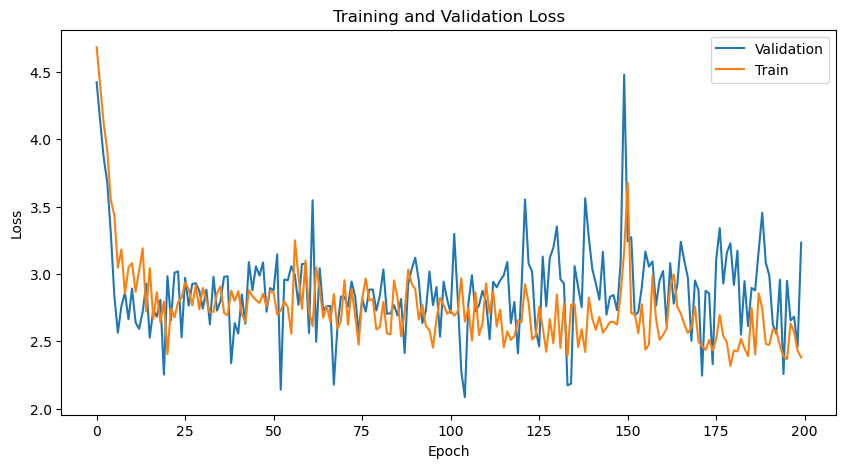

In [16]:
####################################################################################
#Training
####################################################################################
train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    running_loss = 0
    ct = 0
    for x,y in train_loader:
        ct += 1
        optimizer.zero_grad() #zero the grad
        yhat_list, _ = model(x.to(device)) #Forward

        loss_list = []
        for i in range(0,7):
            #cur_l = BCE_WithRegularization(yhat_list[i].to('cpu'), y[i].to('cpu'),0.01, 'None',  model, [1,8]) #loss with regularization
            #loss_list.append(cur_l)
            loss_list.append(loss_func(yhat_list[i].squeeze(),y[:,i].to(device))) #compute loss

        for i in range(0,7):
            if i != 6:
                loss_list[i].backward(retain_graph=True)   #backward  
            else:
                loss_list[i].backward() 
        
        #Sum loss
        loss = sum(loss_list)
        optimizer.step() #Optimize
        running_loss += loss.detach().item() #acuumalated average batch loss

    #Training loss 
    epoch_loss = running_loss/len(train_loader) #accumulated loss/total # batches (averaged loss over batches)
    train_loss.append(epoch_loss)

    #Validation
    with torch.no_grad():
        val_running_loss = 0
        for x_val,y_val in val_loader:
            val_yhat_list, _ = model(x_val.to(device))
            
            val_loss_list = []
            for i in range(0,7):
                val_loss_list.append(loss_func(val_yhat_list[i].squeeze(),y_val[:,i].to(device))) #compute loss

            val_loss = sum(val_loss_list)
            val_running_loss += val_loss.detach().item() 
        val_epoch_loss = val_running_loss/len(val_loader) 
        valid_loss.append(val_epoch_loss)
    
    print("Epoch"+ str(epoch) + ":",
          "Train-LOSS:" + "{:.5f}".format(train_loss[epoch]) + ", " +
          "Valid-LOSS:" +  "{:.5f}".format(valid_loss[epoch]))
    
    #Save model parameters
    torch.save(model.state_dict(), outdir + "model" + str(epoch))


#Plot LOSS
plot_LOSS(train_loss,valid_loss, outdir)
log_message("End Training", outdir3 + "training_log.txt")

In [34]:
#Loss
loss_func = torch.nn.BCELoss()
THRES = 0.1
#Prediction
with torch.no_grad():
    pred_prob_list, test_attention = model(test_data.x.to(device))

    #Get y_True list
    y_true_list = test_data.y
    
    #order matches with SELECTED_MUTATION_COLS
    test_loss_list = []
    for i in range(0,7):
        test_loss_list.append(loss_func(pred_prob_list[i].squeeze(),y_true_list[:,i].to(device)).detach().cpu().numpy())
        print("Test-Loss " + SELECTED_LABEL[i] + ":" + "{:.5f}".format(test_loss_list[i]))
    #Total loss
    test_loss = sum(test_loss_list)
    print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))

    #prediction list per outcome
    test_pred_list = []
    test_pred_class_list = []
    for i in range(0,7):
         test_pred_list.append(torch.flatten(pred_prob_list[i].squeeze().detach().cpu()))
         #test_pred_class_list.append(torch.flatten(torch.round(test_pred_list[i])))
         test_pred_class_list.append([(t > THRES).float().numpy() for t in test_pred_list[i]])

#Prediction df
tile_pred_df_list = []
for i in range(0,7):
   tile_pred_df_list.append(pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                            #"Test_IDs":  test_IDs_df['TEST_IDS'], 
                            "Y_True": torch.flatten(y_true_list[:,i]).tolist(), 
                            "Pred_Prob" :  test_pred_list[i].tolist(),
                            "Pred_Class": [float(value) for value in test_pred_class_list[i]],
                            "OUTCOME": SELECTED_LABEL[i]}))
tile_pred_df = pd.concat(tile_pred_df_list)
tile_pred_df.to_csv(proj_dir + "intermediate_data/pred_out/" + SELECTED_MUTATION + "/tile_pred_df.csv",index = False)

comb_perf_list = []
for mut in SELECTED_LABEL:
    cur_tile_pred_df = tile_pred_df.loc[tile_pred_df['OUTCOME'] == mut]
    cur_tile_level_perf = compute_performance(cur_tile_pred_df['Y_True'],cur_tile_pred_df['Pred_Prob'],cur_tile_pred_df['Pred_Class'],'TILE_LEVEL')
    cur_tile_level_perf['OUTCOME'] = mut
    comb_perf_list.append(cur_tile_level_perf)
comb_perf = pd.concat(comb_perf_list)

################################################
#Create output dir
################################################
indir = proj_dir + "intermediate_data/pred_out/"  + SELECTED_MUTATION + "/"
outdir =  proj_dir + "intermediate_data/pred_out/" + SELECTED_MUTATION + "/perf_table/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

comb_perf.to_csv(outdir + "perf.csv",index = True)
print(comb_perf)
print(comb_perf['AUC'].mean())

Test-Loss AR:0.40711
Test-Loss MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2:0.44991
Test-Loss PTEN:0.55863
Test-Loss RB1:0.30909
Test-Loss TP53:0.64975
Test-Loss TMB_HIGHorINTERMEDITATE:0.30580
Test-Loss MSI_POS:0.31583
Test-Loss TOTAL: 2.99612
             AUC   ACC    F1    F2    F3  Recall  Precision  Specificity  \
TILE_LEVEL  0.66  0.70  0.25  0.32  0.36    0.40       0.18         0.74   
TILE_LEVEL  0.58  0.48  0.28  0.43  0.52    0.67       0.17         0.44   
TILE_LEVEL  0.57  0.22  0.37  0.59  0.74    1.00       0.22         0.00   
TILE_LEVEL  0.73  0.72  0.35  0.52  0.61    0.75       0.23         0.72   
TILE_LEVEL  0.66  0.42  0.58  0.78  0.87    1.00       0.41         0.04   
TILE_LEVEL  0.68  0.82  0.22  0.28  0.30    0.33       0.17         0.86   
TILE_LEVEL  0.68  0.85  0.25  0.29  0.31    0.33       0.20         0.89   

              PR_AUC                                           OUTCOME  
TILE_LEVEL  0.224167                                                A

In [80]:
pred_prob_list, test_attention = model(test_data.x[0][0:100,].unsqueeze(0).to(device))
print(test_data.x[0][0:100,].shape)

torch.Size([100, 2048])


In [91]:
check_model = nn.Linear(2048, 128)
sp1  = test_data.x[0][0:100,]
sp2  = test_data.x[0][0:8,]
print(sp1.shape)
print(check_model(sp1).shape)
check_model(sp2).shape

torch.Size([100, 2048])
torch.Size([100, 128])


torch.Size([8, 128])

In [35]:
#TODO: Get attention score
all_att = []
for i in range(0,40):
    cur_id = test_ids[i]
    cur_attent = pd.DataFrame(minmax_normalize(test_attention[i]).cpu().numpy())
    cur_attent.rename(columns = {0: 'ATT'}, inplace = True)
    input_dir = tile_path + cur_id + '/' + 'features/' + 'train_features_' + pretrain_model_name + '.h5'
    cur_label_df = pd.read_hdf(input_dir, key='tile_info')
    cur_att_df = pd.concat([cur_label_df,cur_attent], axis = 1)
    all_att.append(cur_att_df)
all_att_df = pd.concat(all_att)

In [43]:
#Load slide
i = 6
pt = test_ids[i]
print(pt)

save_image_size = 250
pixel_overlap = 100
limit_bounds = True

_file = wsi_path + pt + ".tif"
oslide = openslide.OpenSlide(_file)
save_name = str(Path(os.path.basename(_file)).with_suffix(''))

#Generate tiles
tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)

#get level 0 size in px
l0_w = oslide.level_dimensions[0][0]
l0_h = oslide.level_dimensions[0][1]

mag_target_prob = 2.5
lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
heatmap = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
#Attention
cur_attent = pd.DataFrame(minmax_normalize(test_attention[i]).cpu().numpy())
cur_attent.rename(columns = {0: 'ATT'}, inplace = True)
input_dir = tile_path + pt + '/' + 'features/' + 'train_features_' + pretrain_model_name + '.h5'
cur_label_df = pd.read_hdf(input_dir, key='tile_info')
cur_att_df = pd.concat([cur_label_df,cur_attent], axis = 1)
cur_att_df = cur_att_df.sort_values(by = ['ATT'], ascending = False) 

#Pull tiles
att_img = pull_tiles(cur_att_df, tiles, tile_lvls)


outdir =  proj_dir + "intermediate_data/pred_out/MT/top_tiles/" + pt + "/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

#Grab tiles and plot
for i in range(0,5): #top5
    cur_row = cur_att_df.iloc[i]
    cur_img = att_img[i]
    #Save tile
    cur_att = cur_row['ATT']
    tile_save_name = "TF" + str(cur_att) + ".png"
    cur_img.save(os.path.join(outdir, tile_save_name))
    
cur_att_df = cur_att_df.sort_values(by = ['ATT'], ascending = True) 

#Pull tiles
att_img = pull_tiles(cur_att_df, tiles, tile_lvls)

outdir =  proj_dir + "intermediate_data/pred_out/MT/bot_tiles/" + pt + "/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

#Grab tiles and plot
for i in range(0,5): #top5
    cur_row = cur_att_df.iloc[i]
    cur_img = att_img[i]
    #Save tile
    cur_att = cur_row['ATT']
    tile_save_name = "TF" + str(cur_att) + ".png"
    cur_img.save(os.path.join(outdir, tile_save_name))

OPX_062


In [ ]:
# Apply the function to each row
att_dict = cur_att_df.apply(convert_to_dict, axis=1)

# Map probabilities to the heatmap
for att_coor in att_dict:
    startx, endx, starty, endy  = att_coor['coords']
    prob = att_coor['att']
    
    heatmap[starty:endy+1, startx:endx+1] = prob

# Plot the heatmap
plt.imshow(heatmap, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Prediction Probability')
plt.title('Attention Scores')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()